In [1]:
from mcmc_tools import EmceeHammer
import numpy as np
import matplotlib.pyplot as plt
from ammonia_hfs_model import populate_params, NH3_model, NH2D_model
from spectroscopic_data import get_spectroscopic_data, ortho_NH3_pf, para_NH3_pf, NH2D_pf, NH3_pf
%matplotlib widget
%load_ext autoreload
%autoreload 2

plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.sans-serif": ["Times"]}
)

Data used for partition function: /home/yamato/Project/IRAS4A_ammonia/data/partition_function/NH3_partition_function_fromRotConst.dat
Data are linearly interpolated.
Data used for partition function: /home/yamato/Project/IRAS4A_ammonia/data/partition_function/o-NH3_partition_function_fromRotConst.dat
Data are linearly interpolated.
Data used for partition function: /home/yamato/Project/IRAS4A_ammonia/data/partition_function/p-NH3_partition_function_fromRotConst.dat
Data are linearly interpolated.
Data used for partition function: /home/yamato/Project/IRAS4A_ammonia/data/partition_function/NH2D_partition_function.dat
Data are linearly interpolated.


In [2]:
fit_type = "OPR_fixed"
transition = ["NH3_33", "NH3_44", "NH3_55", "NH2D_33", "NH2D_44"]

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.99999998
  1.99999998  2.99999998  3.99999998  4.99999998  5.99999998  6.99999998
  7.99999998  8.99999998  9.99999998 10.99999998 11.99999998  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ] km / s
[1.04297768e-02 2.75403919e-03 5.10059948e-04 6.81770153e-05
 6.57860486e-06 4.58261435e-07 2.30428429e-08 8.36255299e-10
 2.21315976e-11 1.84235106e-11 1.00676276e-09 4.05981725e-08
 1.18133370e-06 2.48088771e-05 3.76022128e-04 4.10911251e-03
 3.21808736e-02 1.76665975e-01 6.46848942e-01 1.50038933e+00
 2.27494749e+00 2.62280042e+00 2.68645222e+00 2.55752492e+00
 2.08144547e+00 1.22033452e+00 4.56897074e-01 1.09613683e-01
 1.78536358e-02 2.05760664e-03 1.

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


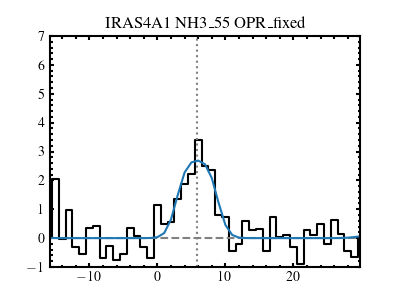

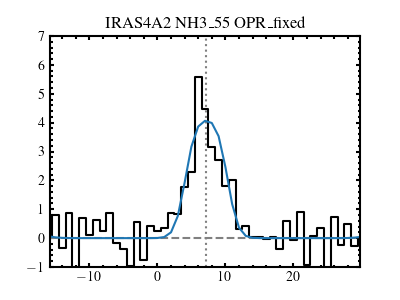

In [3]:
# comparison with spectrum
import pickle
import astropy.units as u
from astropy.modeling.models import Gaussian2D
from astropy.convolution import Gaussian2DKernel, convolve
from analysis_utils import FWHM_to_sigma

integration_range = {
    "NH3_11": np.array([-14, -11, -3, 1, 4, 9, 12, 16, 23, 29]),
    "NH3_22": np.array([-13, -8, 4, 10, 21, 26]),
    "NH3_33": np.array([-16, 30]),
    "NH3_44": np.array([1, 12]),
    "NH3_55": np.array([1, 12]),
    "NH2D_33": np.array([7, 10]),
    "NH2D_44": np.array([4, 10]),
}  # in km/s

trans = "NH3_55"
specpath = "./data/spectrum/"
sources = ["IRAS4A1", "IRAS4A2"]
flux = {}
model_func = {}

pf = {
    "OPR_free": {
        "NH3_33": ortho_NH3_pf,
        "NH3_44": para_NH3_pf,
        "NH3_55": para_NH3_pf,
        "NH2D_33": NH2D_pf,
        "NH2D_44": NH2D_pf,
    },
    "OPR_fixed": {
        "NH3_33": NH3_pf,
        "NH3_44": NH3_pf,
        "NH3_55": NH3_pf,
        "NH2D_33": NH2D_pf,
        "NH2D_44": NH2D_pf,
    },
}

for source in sources:
    specfilename = (
        specpath
        + f"{source}_{trans}.robust2.0.dv1.0.clean.image.pbcor.fits.spectrum.pickle"
    )
    xlim = (-15.8, 29.8)
    ylim = (-1, 7)

    with open(specfilename, "rb") as f:
        data = pickle.load(f)
    velax = data.coord.pixel_to_world(np.arange(data.spectrum.size)).quantity.to(
        u.km / u.s, equivalencies=u.doppler_radio(data.restfreq)
    )
    spec = data.spectrum.to(u.mJy / u.beam)

    # model
    filename = f"data/fit/{source}_{'_'.join([trans for trans in transition])}_{fit_type}_v2.h5"
    hammer = EmceeHammer()
    hammer.load_backend(filename)
    MAP_param = hammer.get_MAP_params()
    dv_FWHM, v0, N, T, s = populate_params(MAP_param, transition, fit_type)

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(velax, spec, drawstyle="steps-mid", color="black")
    ax.set(xlim=xlim, ylim=ylim)
    ax.axhline(y=0.0, color="grey", ls="dashed")
    ax.axvline(x=v0[trans].value, color="grey", ls="dotted")

    # overplot model
    rotdata = get_spectroscopic_data(trans, hfs=False)
    hfsdata = get_spectroscopic_data(trans, hfs=True)
    beam = (data.beam.major.to(u.arcsec).value, data.beam.minor.to(u.arcsec).value)
    spec_model = NH3_model if "NH3" in trans else NH2D_model
    spectrum = spec_model(
        velax=velax,
        beam=beam,
        rotdata=rotdata,
        hfsdata=hfsdata,
        dv_FWHM=dv_FWHM[trans],
        v0=v0[trans],
        N=N[trans],
        T=T,
        s=s,
        pf=pf[fit_type][trans],
    ).to("mJy/beam", equivalencies=u.brightness_temperature(data.restfreq, data.beam))

    ax.plot(velax, spectrum)
    ax.set_title(" ".join([source, trans, fit_type]))

    n_range = int(len(integration_range[trans]) / 2)
    for i in range(n_range):
        idx = i * 2
        lower = integration_range[trans][idx] - 0.1
        upper = integration_range[trans][idx + 1] + 0.1
        velax = np.where((velax.value >= lower) & (velax.value <= upper), velax, 0.0)

    print(velax)
    print(spectrum)
    spectrum[velax == 0.0] = 0.0

    f = np.trapz(spectrum, velax)
    mf = Gaussian2D(
        amplitude=1.0,
        x_mean=0.0,
        y_mean=0.0,
        x_stddev=FWHM_to_sigma(s),
        y_stddev=FWHM_to_sigma(s),
    )
    flux[source] = f
    model_func[source] = mf


In [195]:
# import observed cube
from qdisk.classes import FitsImage
from qdisk.plot import Map
from sourcedictionary import source_dict
import numpy as np
from analysis_utils import cpal
from astropy.coordinates import SkyCoord

center_coord = source_dict["IRAS4A"]["IRAS4A2"]["radec"]
xlim = (-2.5, 4)
ylim = (-4, 2.5)
mom0path = "./data/mom0/"
mom0name = mom0path + f"IRAS4_{trans}.robust2.0.dv1.0.clean.image_M0.fits"

# rms
# dmom0 = FitsImage(mom0name.replace("_M0.fits", "_dM0.fits"))
# rms = np.nanmedian(dmom0.data)
mom0 = FitsImage(mom0name)
mom0.estimate_rms(rmin=8)
rms = mom0.rms
print(rms)

mom0 = FitsImage(mom0name, xlim=xlim, ylim=ylim)

2.051995809506991


deg
deg


Text(0.5, 1.0, 'Residual')

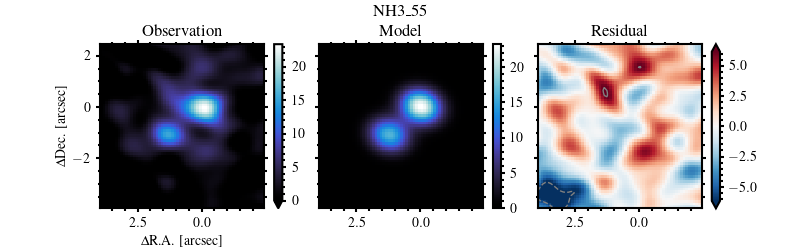

In [196]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5), sharex=True, sharey=True)

method = "pcolorfast"
shading = None
fig.suptitle(trans)

# observation
ax = axes[0]
mom0.shift_phasecenter_toward(center_coord)
obsmap = Map(fitsname_or_data=mom0.data, x=mom0.x, y=mom0.y, ax=ax)
obsmap.plot_colormap(cmap=cpal, vmin=0.0, method=method)#, shading=shading)
obsmap.add_colorbar()
obsmap.set_labels(xlabel="$\Delta$R.A. [arcsec]", ylabel="$\Delta$Dec. [arcsec]")
obsmap.ax.set_title("Observation")

# model
ax = axes[1]
model = 0
for source in sources:
    mom0.shift_phasecenter_toward(center_coord)
    c = SkyCoord(center_coord, frame="icrs")
    dx, dy = c.spherical_offsets_to(SkyCoord(source_dict["IRAS4A"][source]["radec"], frame="icrs"))
    mom0.shift_phasecenter(dx=dx.to(u.arcsec).value, dy=dy.to(u.arcsec).value)
    x, y = np.meshgrid(mom0.x, mom0.y)
    m = model_func[source](x, y)

    # convolve with beam
    print(data.beam.pa.unit)
    kernel = Gaussian2DKernel(x_stddev=FWHM_to_sigma(beam[0])/mom0.dpix, y_stddev=FWHM_to_sigma(beam[1])/mom0.dpix, theta=90*u.deg+data.beam.pa)
    m = convolve(m, kernel)
    m /= np.max(m) 
    m *= flux[source].value
    model += m

modelmap = Map(fitsname_or_data=model, x=mom0.x, y=mom0.y, ax=ax)
modelmap.plot_colormap(cmap=cpal, vmin=0.0, method=method)#, shading=shading)
modelmap.add_colorbar()
modelmap.ax.set_title("Model")

# residual
ax = axes[2]
res = obsmap.data - modelmap.data
resmap = Map(fitsname_or_data=res, x=mom0.x, y=mom0.y, ax=ax)
resmap.plot_colormap(cmap="RdBu_r", vmin=-3*rms, vmax=3*rms, method=method)#, shading=shading)
resmap.overlay_contour(levels=np.array([3, 4, 5])*rms, linestyle="solid")
resmap.overlay_contour(levels=-np.array([5, 4, 3])*rms, linestyle="dashed")
resmap.add_colorbar()
resmap.ax.set_title("Residual")


In [102]:
data.beam.pa.value

72.81893187029